In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Load your CSV data into a pandas DataFrame
df = pd.read_csv('../../../data/processed/tokenized_data_sample_with_custom_stopwords.csv')

# Load the vectorized features from the .npy file
vectorized_features = np.load('../../../data/processed/sample_vectorized_features_with_custom_stopwords_word2vec.npy')

feature_vectors = pd.DataFrame(vectorized_features)


feature_vectors.columns = [f'vec_feature_{i}' for i in range(feature_vectors.shape[1])]

X = feature_vectors # Feature vector
y = df['overall']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.fillna('', inplace=True)
X_test.fillna('', inplace=True)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = rf_model.predict(X_test)


In [2]:
# Print the classification report
print(classification_report(y_test, y_pred))
# Evaluate the model
accuracy = rf_model.score(X_test, y_test)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

         1.0       0.63      0.38      0.47      1236
         2.0       0.75      0.16      0.27       759
         3.0       0.49      0.26      0.34      1082
         4.0       0.54      0.25      0.34      1669
         5.0       0.64      0.95      0.77      5254

    accuracy                           0.63     10000
   macro avg       0.61      0.40      0.44     10000
weighted avg       0.62      0.63      0.58     10000

Accuracy: 0.6279


## Random Forest (w/ Class Weighting)

In [3]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(class_weight=class_weights, random_state=42)
rf_model.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.71      0.30      0.42      1236
         2.0       0.76      0.15      0.25       759
         3.0       0.53      0.21      0.30      1082
         4.0       0.63      0.20      0.30      1669
         5.0       0.61      0.97      0.75      5254

    accuracy                           0.61     10000
   macro avg       0.65      0.37      0.41     10000
weighted avg       0.63      0.61      0.55     10000



## Random Forest (w/ Oversampling minority class)

In [14]:
from imblearn.over_sampling import RandomOverSampler

# Oversample the minority classes (1 to 4-star reviews) automatically
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Initialize and train the logistic regression model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Predict the target variable for the test set
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.58      0.43      0.49      1236
         2.0       0.61      0.21      0.31       759
         3.0       0.43      0.33      0.37      1082
         4.0       0.50      0.34      0.40      1669
         5.0       0.69      0.90      0.78      5254

    accuracy                           0.63     10000
   macro avg       0.56      0.44      0.47     10000
weighted avg       0.61      0.63      0.60     10000



: 

## Random Forest (w/ Undersampling majority class)

In [5]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the majority class (5-star reviews) automatically
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict the target variable for the test set
y_pred = rf_model.predict(X_test)

In [6]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.41      0.52      0.45      1236
         2.0       0.24      0.43      0.30       759
         3.0       0.27      0.44      0.34      1082
         4.0       0.38      0.40      0.39      1669
         5.0       0.87      0.59      0.70      5254

    accuracy                           0.52     10000
   macro avg       0.43      0.47      0.44     10000
weighted avg       0.62      0.52      0.55     10000



In [7]:
# Display class distribution after undersampling
print("\nClass Distribution After Undersampling:")
print(pd.Series(y_train_resampled).value_counts())


Class Distribution After Undersampling:
overall
1.0    2903
2.0    2903
3.0    2903
4.0    2903
5.0    2903
Name: count, dtype: int64


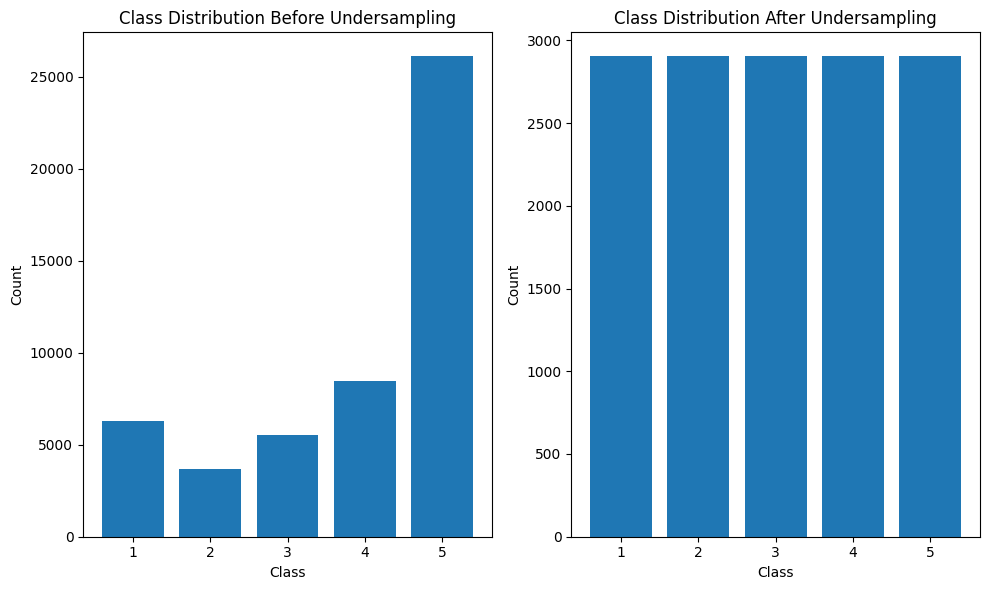

In [8]:
import matplotlib.pyplot as plt

y = df['overall']

# Plot class distribution before and after undersampling
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.title('Class Distribution Before Undersampling')
plt.bar(y.value_counts().index, y.value_counts().values)
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.title('Class Distribution After Undersampling')
plt.bar(pd.Series(y_train_resampled).value_counts().index, pd.Series(y_train_resampled).value_counts().values)
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

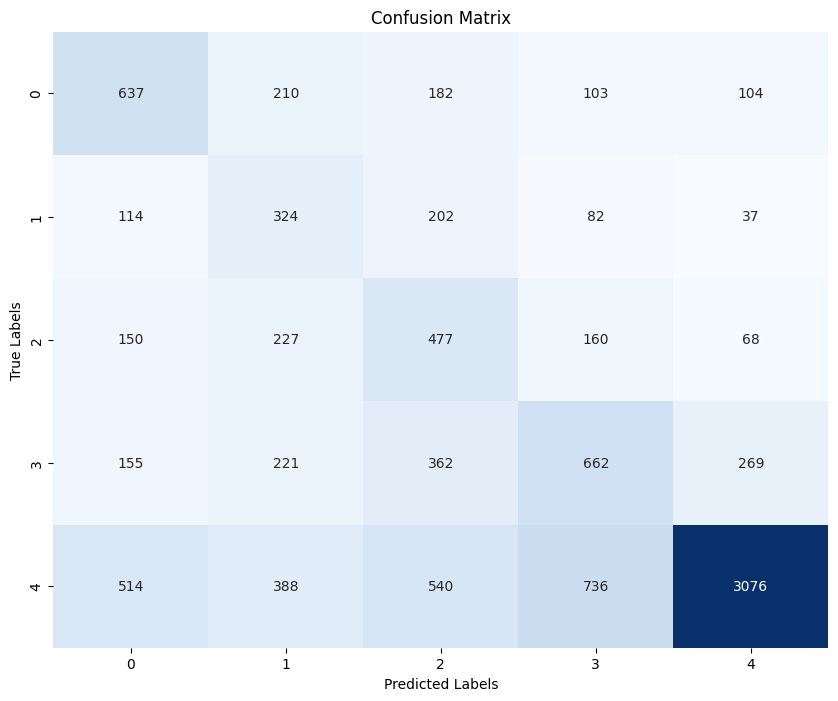

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


C:\Users\lucym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


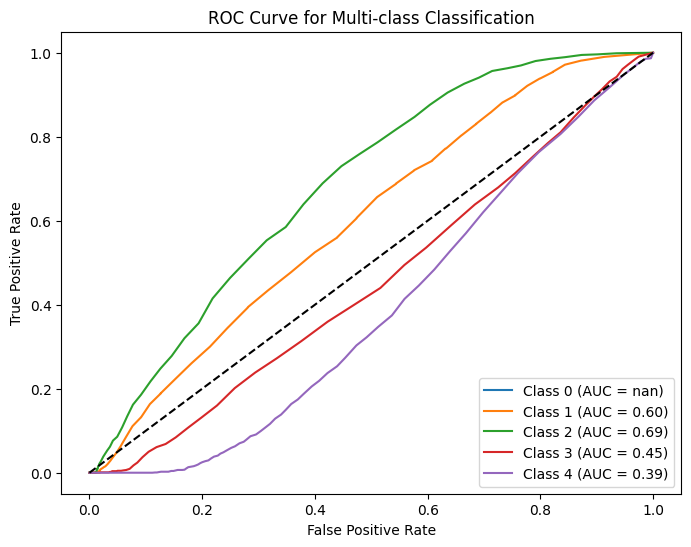

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = rf_model.predict_proba(X_test)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()